In [2]:
import pandas as pd
import pyodbc
import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import math
import matplotlib.patches as mpatches
pd.options.mode.chained_assignment = None 
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter

In [4]:
server = 'mi-testpit.public.12c4ab071bf5.database.windows.net,3342'
user = '_._@nhs.net'
db_dict = 'Dictionary'
db_sus = 'SUS'

In [5]:
Authentication='ActiveDirectoryInteractive'
driver= '{ODBC Driver 17 for SQL Server}'
conn = pyodbc.connect('DRIVER='+driver+
                      ';SERVER='+server+
                      ';PORT=1433;DATABASE='+db_sus+
                      ';UID='+user+
                      ';AUTHENTICATION='+Authentication
                      )

print(conn)

In [6]:
query = '''
exec [Towerhamlets].[dbo].[HVLC_Surgical_Hubs]
'''

#file = open(r'N:\THCCG\NHSTHCCG\Financial strategy\Programmes\2. Planned Care\2.08 Surgical Hubs\0. Data and Preprocessing\HVLC_Surgical_Hubs_v1.3_local.sql','r')
#script = file.read()
df = pd.read_sql(query, conn)

C:\Source\VDI-InsightsTeam\WPy64-39100\python-3.9.10.amd64\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [8]:
df.loc[:, 'FinYear'] = pd.to_datetime(df['Date']).dt.to_period('Q-Mar').dt.qyear.apply(lambda x: '{}/{}'.format(str(x-1)[2:4], str(x)[2:4]))
df['Date'] =pd.to_datetime( df['Date'])
df = df[df['Specialty'] != 'Spinal Surgery']

In [9]:
conditions = [
            (df['Date'] < '2020-03-01'),
            (df['Date'] >= '2020-03-01') & (df['Date'] < '2021-05-01'),
            (df['Date'] >= '2021-05-01')]

choices = ['Phase 1', 'Phase 2', 'Phase 3']
df['Phase'] = np.select(conditions, choices, default='Unknown')
df = df.reset_index(drop=True)

In [10]:
boroughs = ['Hackney','Newham','Tower Hamlets','Waltham Forest','City of London','Redbridge','Havering','Barking and Dagenham']
df['Borough_NEL'] = df['Borough'].apply(lambda x: x if x in boroughs else ('Unknown' if not x else 'non-NEL') )

trusts = ['Barking, Havering and Redbridge University Hospitals NHS Trust', 'Barts Health NHS Trust',
          'Homerton Healthcare NHS Foundation Trust', 'Moorfields Eye Hospital NHS Foundation Trust']
df['Key_Trusts'] = df['ServiceProviderName'].apply(lambda x:  x if x in trusts else 'Other' )

In [11]:
trust_short = {'Barking, Havering and Redbridge University Hospitals NHS Trust': 'BHRUT',
               'Barts Health NHS Trust': 'Barts',
               'Homerton Healthcare NHS Foundation Trust': 'Homerton',
               'Moorfields Eye Hospital NHS Foundation Trust': 'Moorfields',
               'Other': 'Other'}
df['Key_Trusts'] = df['Key_Trusts'].map(trust_short)

In [12]:
df2 = df.set_index('Date')

In [23]:
spec_df = df2[df2['Specialty'] == 'Orthopaedics' ]
# spec_df.loc[:,'YearMonth'] = spec_df['Date'].dt.strftime('%Y-%m')

spec_df = spec_df.groupby([pd.Grouper(freq='M'), 'Phase', 'Key_Trusts'])['Total_Activity'].sum().reset_index()
    
spec_df = spec_df.groupby(['Date','Phase','Key_Trusts'],as_index = False).agg({'Total_Activity':'sum'})

phase_one = spec_df[spec_df['Phase']=='Phase 1']
mean_dict = phase_one.groupby('Key_Trusts').mean().to_dict()['Total_Activity']
phase_two_three = spec_df[spec_df['Phase']!='Phase 1']

phase_two_three.loc[:, 'mean_phase_one'] = phase_two_three['Key_Trusts'].replace(mean_dict)

phase_two_three.loc[:,'perc_of_p1_avg'] = (phase_two_three['Total_Activity'].fillna(0) / phase_two_three['mean_phase_one'])*100
    
phase_two_three = phase_two_three.reset_index().set_index('Date')
    
#     phase_two_three = phase_two_three.drop(columns=['Phase', 'index'])
pivot_spec_trust = pd.pivot_table(phase_two_three, values='perc_of_p1_avg', index='Date', columns=['Key_Trusts'])

C:\Users\Matteo.Mazzeri\AppData\Local\Temp\ipykernel_5164\3156165226.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_two_three.loc[:, 'mean_phase_one'] = phase_two_three['Key_Trusts'].replace(mean_dict)
C:\Users\Matteo.Mazzeri\AppData\Local\Temp\ipykernel_5164\3156165226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_two_three.loc[:,'perc_of_p1_avg'] = (phase_two_three['Total_Activity'].fillna(0) / phase_two_three['mean_phase_one'])*100


In [19]:
mean_dict

{'BHRUT': 57.857142857142854,
 'Barts': 103.45714285714286,
 'Homerton': 30.8,
 'Other': 153.85714285714286}

In [22]:
phase_two_three

,Date,Phase,Key_Trusts,Total_Activity,mean_phase_one
140,2020-03-31,Phase 2,BHRUT,24,57.857143
141,2020-03-31,Phase 2,Barts,48,103.457143
142,2020-03-31,Phase 2,Homerton,16,30.800000
143,2020-03-31,Phase 2,Other,108,153.857143
144,2020-04-30,Phase 2,BHRUT,3,57.857143
...,...,...,...,...,...
239,2022-04-30,Phase 3,Other,152,153.857143
240,2022-05-31,Phase 3,BHRUT,62,57.857143
241,2022-05-31,Phase 3,Barts,82,103.457143
242,2022-05-31,Phase 3,Homerton,26,30.800000


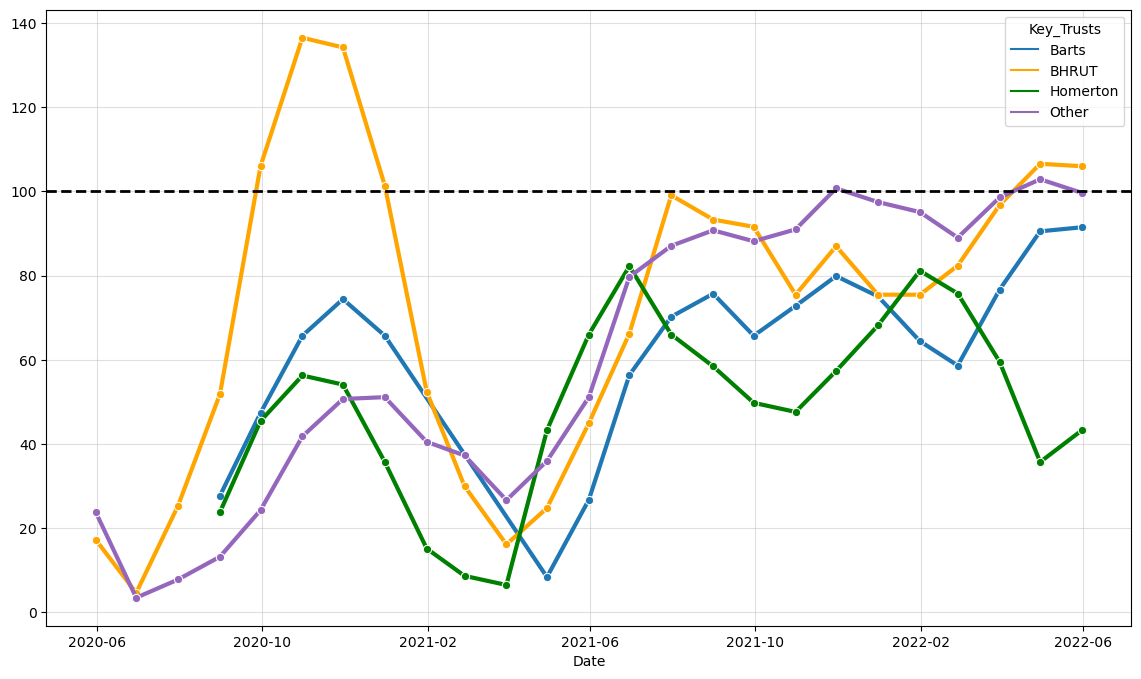

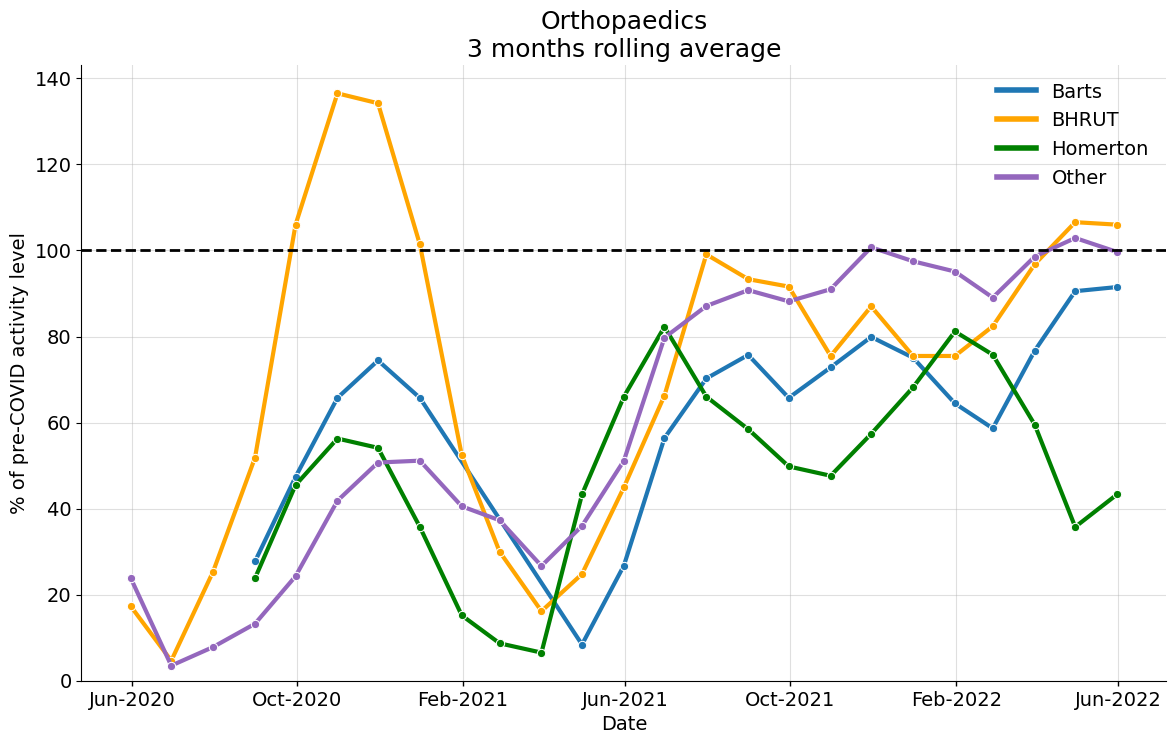

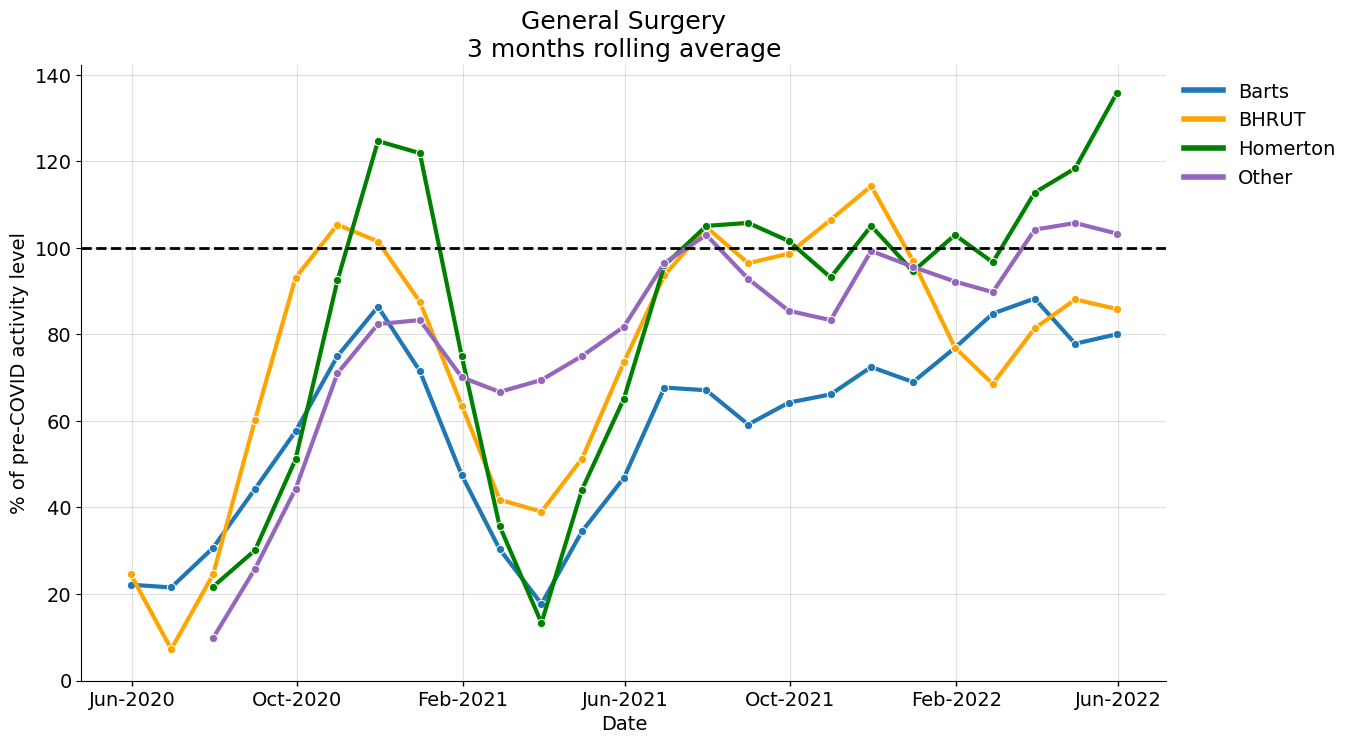

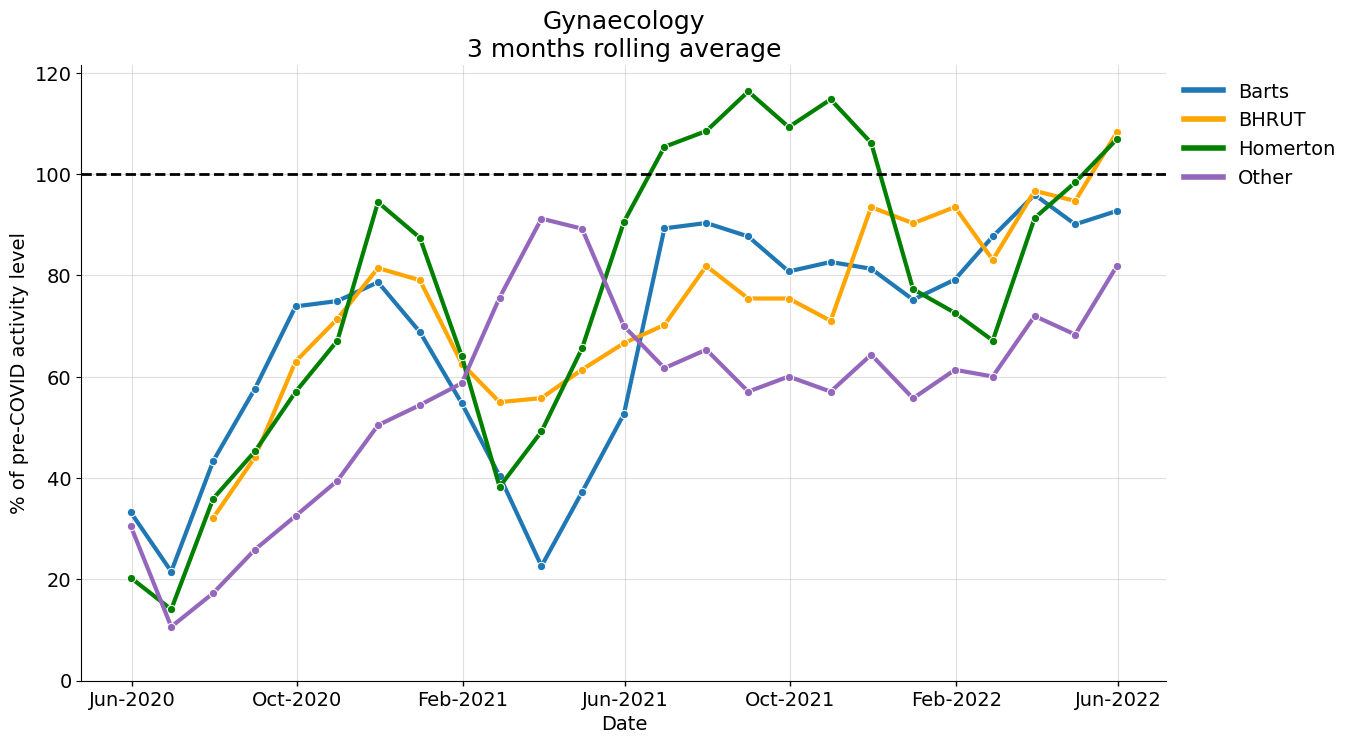

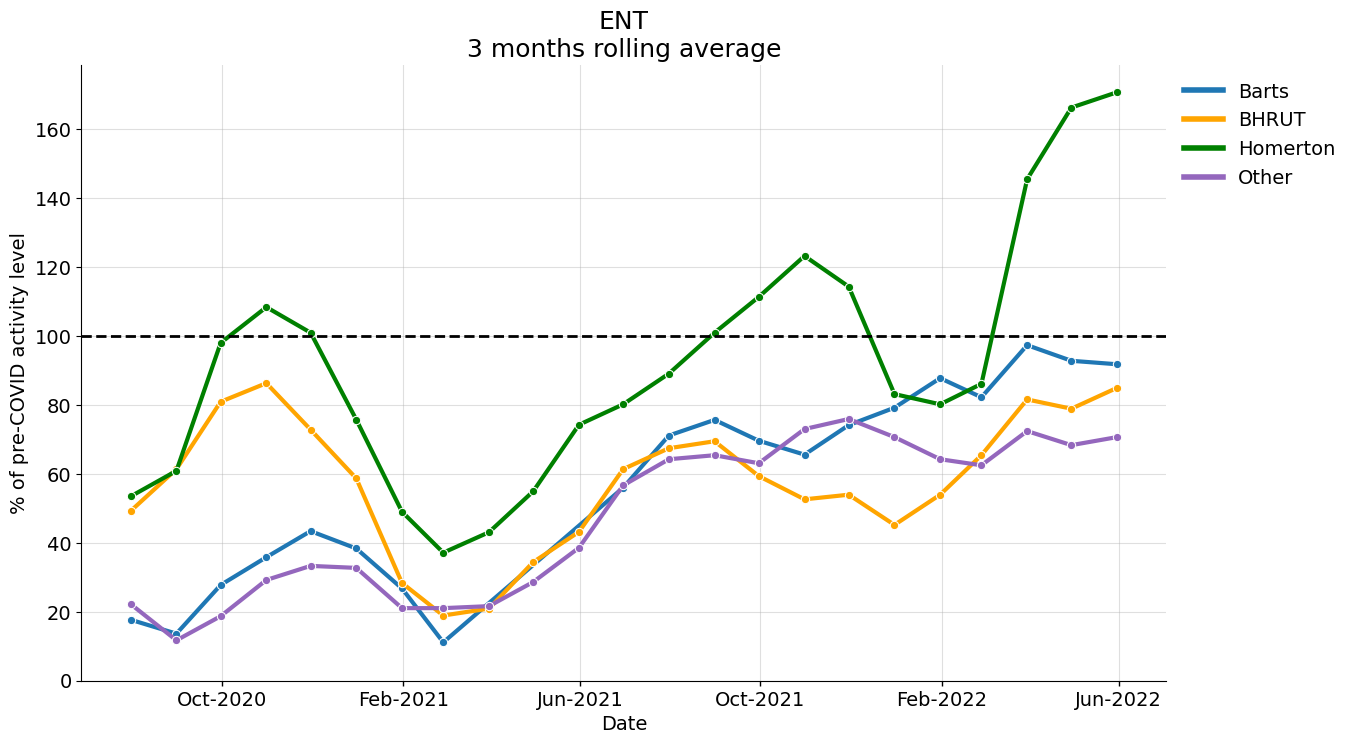

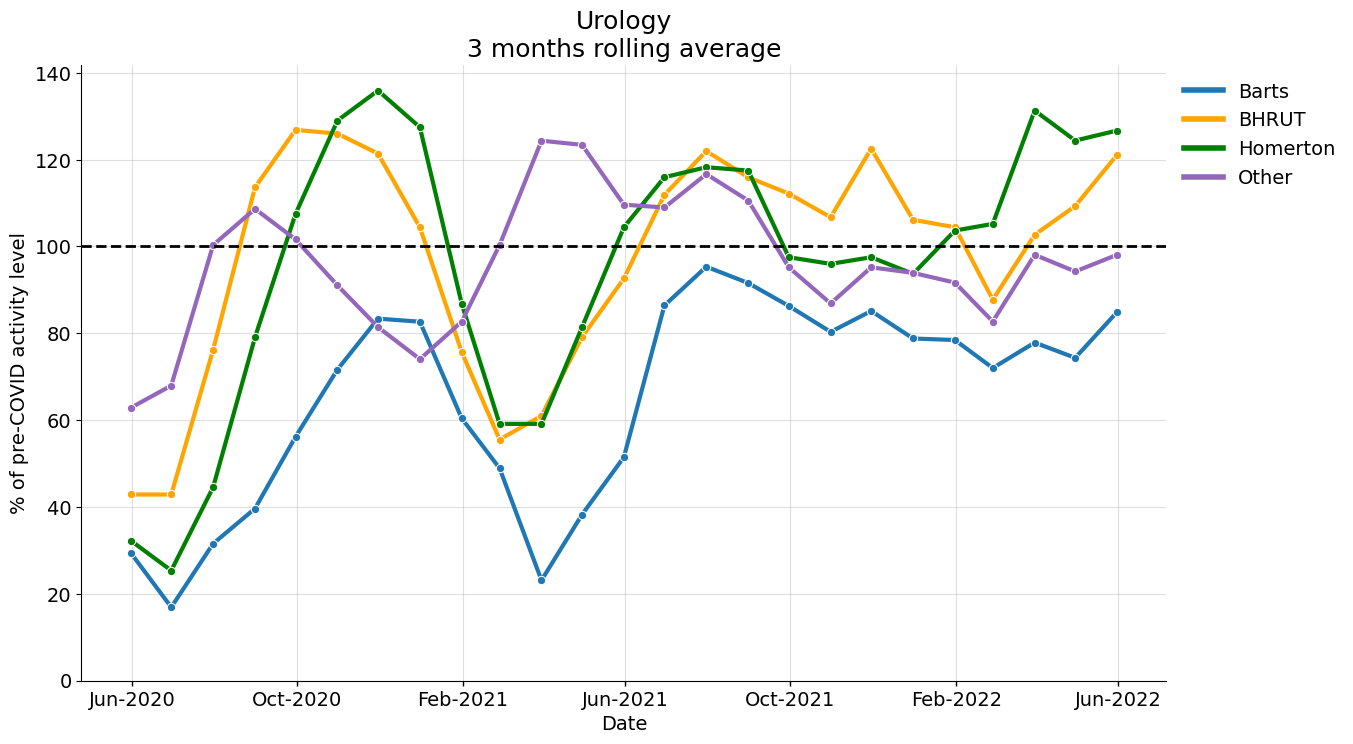

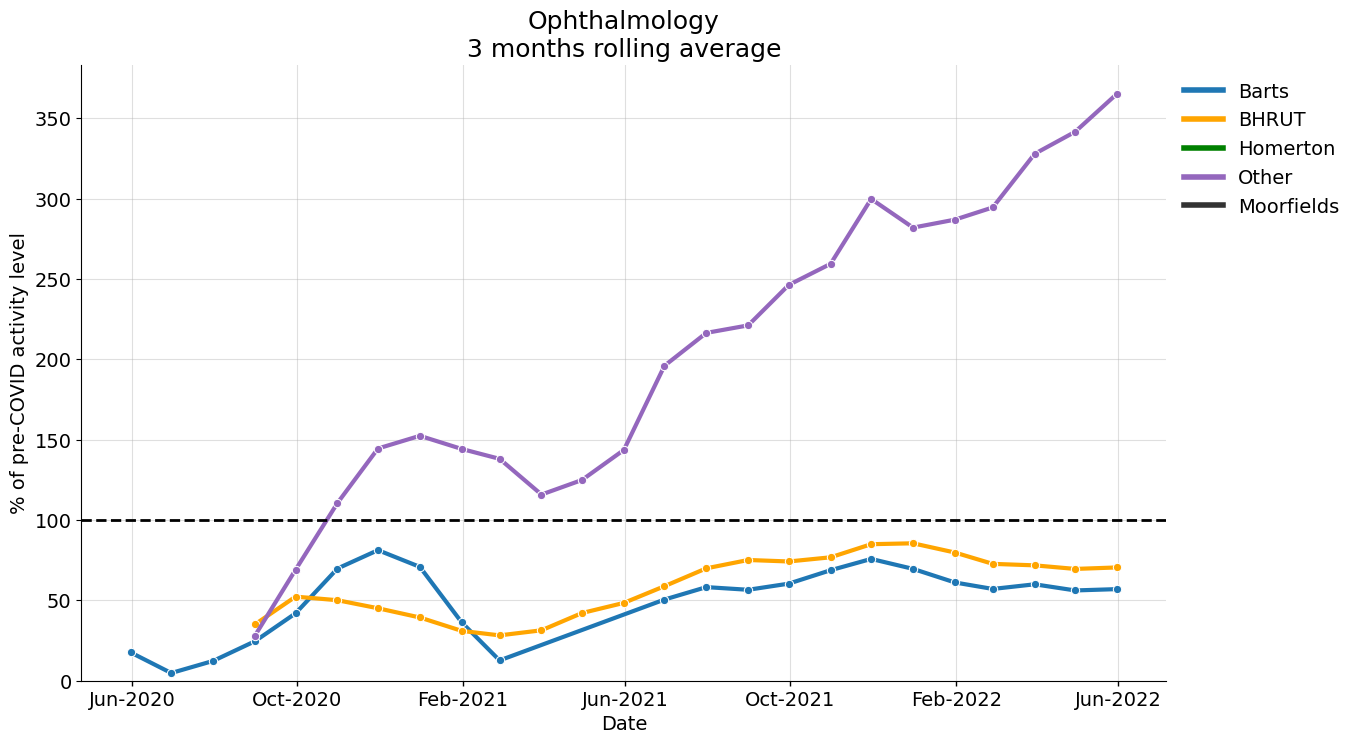

In [26]:
for i in df2['Specialty'].unique():
    spec_df = df2[df2['Specialty'] == i ]
# spec_df.loc[:,'YearMonth'] = spec_df['Date'].dt.strftime('%Y-%m')

    spec_df = spec_df.groupby([pd.Grouper(freq='M'), 'Phase', 'Key_Trusts'])['Total_Activity'].sum().reset_index()
    
    # spec_df = spec_df.groupby(['Date','Phase','Key_Trusts'],as_index = False).agg({'Total_Activity':'sum'})

    phase_one = spec_df[spec_df['Phase']=='Phase 1']
    mean_dict = phase_one.groupby('Key_Trusts').mean().to_dict()['Total_Activity']
    phase_two_three = spec_df[spec_df['Phase']!='Phase 1']

    phase_two_three.loc[:, 'mean_phase_one'] = phase_two_three['Key_Trusts'].replace(mean_dict)

    phase_two_three.loc[:,'perc_of_p1_avg'] = (phase_two_three['Total_Activity'].fillna(0) / phase_two_three['mean_phase_one'])*100
    
    phase_two_three = phase_two_three.reset_index().set_index('Date')
    
    #     phase_two_three = phase_two_three.drop(columns=['Phase', 'index'])
    pivot_spec_trust = pd.pivot_table(phase_two_three, values='perc_of_p1_avg', index='Date', columns=['Key_Trusts'])
    
    sns.reset_defaults()
    plt.figure(figsize=(14, 8))

    ax = sns.lineplot(data=pivot_spec_trust.rolling(window=3).mean()
                      , hue_order = ['Barts','BHRUT','Homerton', 'Other'], 
                      palette=[sns.color_palette('tab10')[0], 'orange', 'green', sns.color_palette('tab10')[4]], marker='o', dashes=False,  linewidth = 3)
    
    plt.axhline(y=100,color='k',linestyle = '--', linewidth=2)
    ax.grid(True, alpha=0.4)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(DateFormatter("%b-%Y"))
    
    ax.set_xlabel('Date', fontsize=14)
    ax.tick_params(axis='x', direction='out', width=1)

    plt.tick_params(axis='x', direction='out', width=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_ylabel('% of pre-COVID activity level', fontsize=14)
    ax.set_title('{}\n3 months rolling average'.format(i), fontsize=18)
    
    leg = plt.legend(bbox_to_anchor=(1, 1), ncol=1, shadow=True, fontsize=14, frameon=False)
    
    for line in leg.get_lines():
        line.set_linewidth(4)
        
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylim(-0.04)    
    # plt.savefig('{} Percentage of pre COVID activity by Trust.jpg'.format(i).title(), bbox_inches='tight', dpi=500)
    
plt.show()
    
    

In [3]:
data = pd.read_csv(r"N:\THCCG\NHSTHCCG\Financial strategy\Programmes\2. Planned Care\2.08 Surgical Hubs\0. Data and Preprocessing\Waiting List\Surgical Hubs WL v1 - 20220612.csv")


C:\Users\Matteo.Mazzeri\AppData\Local\Temp\ipykernel_17056\2656877411.py:1: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"N:\THCCG\NHSTHCCG\Financial strategy\Programmes\2. Planned Care\2.08 Surgical Hubs\0. Data and Preprocessing\Waiting List\Surgical Hubs WL v1 - 20220612.csv")


In [4]:
data = data[data['WAITING LIST TYPE'] == 'IRTT']

In [5]:
columns = ['SK_PatientID', 'WAITING LIST TYPE', 'REFERRAL REQUEST RECEIVED DATE','REFERRAL TO TREATMENT PERIOD START DATE', 'DV_FINANCIALYEAR', 'DV_FINANCIALMONTH',
           'dv_YearOfBirth',  'Procedure', 'SpecialtyName', 'Trust', 'Hospital', 'CCG', 'dv_Ethnicity','dv_Ethnicity2', 
           'dv_Gender', 'dv_IMD',  'Time on WL', '>52wk', 'dv_LSOA', 'dv_MSOA', 'dv_GP', 'dv_PCN']

In [6]:
df = pd.DataFrame(data=data, columns=columns)

In [7]:

df.loc[:, 'IMD quintiles'] = df['dv_IMD'].replace({1: 1,
2: 1,
3: 2,
4: 2,
5: 3,
6: 3,
7: 4,
8: 4,
9: 5,
10: 5})


In [8]:
#Create new column with Ethnicity grouped

df.loc[:, 'Ethnicity_Group'] = df['dv_Ethnicity'].str.split(':').str[0]
df.loc[:, 'Ethnicity_Group'] = df['Ethnicity_Group'].replace({'NOT STATED': 'Not Provided', 
                                                              'Unknown': 'Not Provided'})

In [9]:
#Modifing waiting time column

df['Time on WL'] = df['Time on WL'].str.replace('days', '')
df['Time on WL'] = pd.to_numeric(df['Time on WL'])

In [11]:
df.loc[:, 'Weeks wait'] = df['Time on WL'] // 7 + 1

In [12]:
#SELECT NEL TRUST ONLY 

NEL_trusts = ['Barts Health NHS Trust', 'Barking, Havering and Redbridge University Hospitals NHS Trust',
              'Homerton Healthcare NHS Foundation Trust',
              'Moorfields Eye Hospital NHS Foundation Trust']
df = df[df['Trust'].isin(NEL_trusts)]

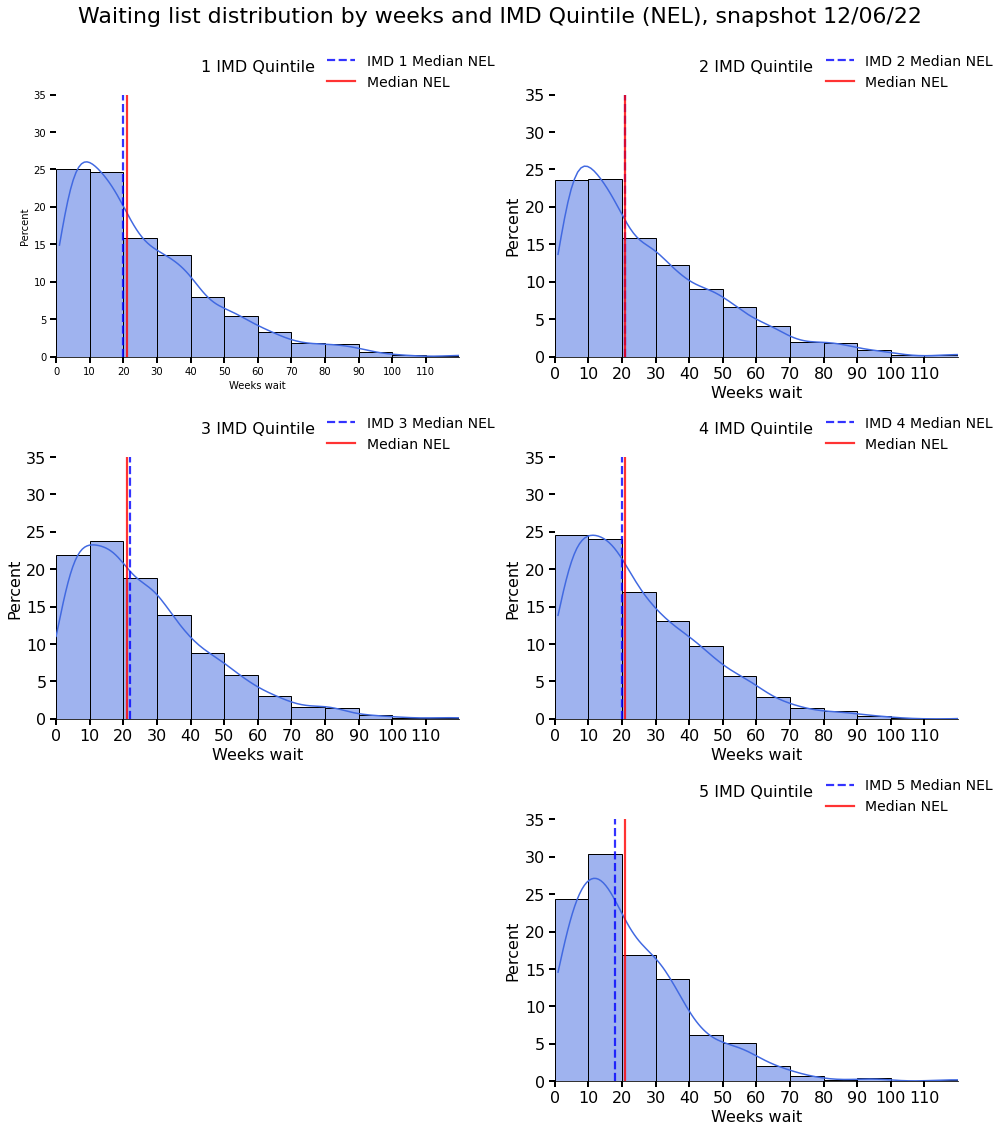

In [13]:
IMD_order = [1, 2, 3, 4, 5]

plt.figure(figsize=(14, 16))

for i, imd in enumerate(IMD_order):
    if i == 0:
        ax1 = plt.subplot(3, 2, i+1)
        # ax1.set_facecolor('#DEDEDE')
    if i == 4:
        ax2 = plt.subplot(3, 2, 6)
        
    else:
        ax = plt.subplot(3, 2, i+1)
    
    # Set the axes title font size

    temp = df[df['IMD quintiles'] == imd]
    
    # bar = sns.ecdfplot(ecdfmnth, color='xkcd:indigo')
    bar = sns.histplot( data = temp, x=(temp['Weeks wait'].dropna()).astype(int), bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
                   stat = 'percent', cumulative = False, kde = True, color = 'royalblue')
    bar.axvline((temp['Weeks wait'].dropna()).median(), linestyle='--', color = 'blue', linewidth=2.2, alpha = .8, 
                label = 'IMD {} Median NEL'.format(imd) )
    bar.axvline(21, linestyle='-', color='red', linewidth = 2.2, alpha = .8, label = 'Median NEL')
    
    plt.xlim(-0.04, 120)

    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    # plt.gca().spines['bottom'].set_color('darkgray')

    plt.legend(loc = "lower right", bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=14, frameon=False)
    
    plt.title('{} IMD Quintile\n'.format(imd), fontsize=16)
    # plt.title('{}, 10/04/22\n'.format(spec))

    # Remove the dashes next to the x and y ticks
    axes = plt.gca()
    plt.tick_params(direction='out', length=6, width=2)
    plt.xticks(np.arange(0, 120, 10))
    plt.yticks(np.arange(0, 40, 5))
    
    plt.rc('axes', titlesize=16)
    # Set the axes labels font size
    plt.rc('axes', labelsize=16)
    # Set the font size for x tick labels
    plt.rc('xtick', labelsize=16)
    # Set the font size for y tick labels
    plt.rc('ytick', labelsize=16)
    # axes.tick_params(axis='both', which='both', length=0)

fig = plt.gcf()
fig.suptitle('Waiting list distribution by weeks and IMD Quintile (NEL), snapshot 12/06/22\n', fontsize=22)   
fig.tight_layout()

#plt.savefig('Mosaico Wait time by IMD Quintile NEL.jpg', dpi=500, bbox_inches='tight')